In [ ]:
import geopandas as gpd
import os
import numpy as np
import pandas as pd
from hashlib import md5
from plotly import express as px
from shapely.geometry import MultiPoint
from shapely import to_wkb


from data.constants import (DATA_FOLDER, LOCAL_CRS, WORLD_CRS)
from data.geo import label_point_dispersion
from data.util import coalesce

In [2]:
bike_rides_in = os.path.join(DATA_FOLDER, "raw", "bike_rides.geoparquet")
bike_stations_in = os.path.join(DATA_FOLDER, "raw", "bike_stations.geojson")

bike_rides_out = os.path.join(DATA_FOLDER, "interim", "bike_rides.geoparquet")

In [3]:
TOLERANCE = .25 # miles

# Pipeline In

In [4]:
bike_rides = gpd.read_parquet(bike_rides_in)
bike_stations = gpd.read_file(bike_stations_in)

In [5]:
# Save for assertions later
nobs = len(bike_rides)
total_rides = bike_rides.filter(like='ride').sum()

# Explore

In [6]:
id_cols = ['station_id','station_name','vintage']

In [7]:
nominal_count = len(set(zip(bike_rides['geometry'].x, bike_rides['geometry'].y)))
id_count = len(bike_rides[id_cols].drop_duplicates())
pct = 1 - id_count / nominal_count
print(f"If id,name,vintage can be 100% centroided, reduces the number of points by {pct:.2%} -> {id_count}")

If id,name,vintage can be 100% centroided, reduces the number of points by 98.86% -> 10420


In [8]:
name_count = bike_rides['station_name'].nunique()
pct = 1 - name_count / nominal_count
print(f"If name can be 100% centroided, reduces the number of points by factor of {pct:.2%} -> {name_count}")

If name can be 100% centroided, reduces the number of points by factor of 99.81% -> 1697


In [9]:
plot_data = bike_rides.pipe(label_point_dispersion, id_cols, metric='max')
plot_data = plot_data.groupby('vintage')['diam_mi'].agg(['mean','max'])
plot_data = plot_data.reset_index().melt(id_vars=['vintage'])
fig = px.bar(plot_data,facet_col='variable',y='value',x='vintage', title='Station dispersion')
fig = fig.update_yaxes(matches=None)
fig.show()
# There doesn't seem to be any particular vinrtage that is responsible for the dispersion.

# Attribute Clustering

Since there aren't any other applicable composite prmiary key columns,
we'll group all roughly-equivalent points together and we'll keep all
non-equivalent points as singleton clusters.

In [10]:
def hash_df(df: pd.DataFrame, out_name: str) -> pd.Series:
    """
    Compute hash function per df row.
    Params:
        df - Must only have string columns
        out_name - name for hashed id series
    """
    return (df
            .sum(axis=1)
            .str.encode('UTF8')
            .apply(md5, usedforsecurity=False)
            .apply(lambda x: x.hexdigest())
            .rename(out_name))

In [12]:
def cluster(df, id_cols, geom='geometry', tol=TOLERANCE):
    """Labels points with new aggregate id. Does not change df shape."""
    df = df.pipe(label_point_dispersion, id_cols, geom, metric='max')
    is_clusterable = df['diam_mi'] < tol
    
    # Compute labels for clusterable points
    cluster_keys = (df[is_clusterable]
                    .filter(id_cols)
                    .drop_duplicates())
    cluster_ids = cluster_keys.pipe(hash_df, 'cluster_id')
    cluster_ids = pd.concat([cluster_keys, cluster_ids], axis=1)

    # Compute labels for non-clusterable points
    non_cluster_keys = (df[~is_clusterable]
                    .filter(id_cols + [geom])
                    .drop_duplicates())

    assert len(pd.Index(cluster_keys[id_cols]).intersection(
        pd.Index(non_cluster_keys[id_cols]))) == 0
    
    # Note: We lose precision when we convert to WKT. That's why
    #       we have fewer isolates. But as a group they still
    #       shouldnt cluster because it doesn't change their group dispersion.
    non_cluster_ids = (non_cluster_keys
                    .assign(wkt = non_cluster_keys[geom].to_wkt(rounding_precision=-1))
                    .drop(columns=[geom])
                    .pipe(hash_df, 'non_cluster_id'))
    non_cluster_ids = pd.concat([non_cluster_keys, non_cluster_ids], axis=1)

    df = df.merge(cluster_ids, how='left').merge(non_cluster_ids, how='left')

    assert all((is_clusterable & df['cluster_id'].notna() & df['non_cluster_id'].isna()) | 
        (~is_clusterable & df['cluster_id'].isna() & df['non_cluster_id'].notna()))
    
    df = df.pipe(coalesce, "cluster_id", "non_cluster_id", "station_cluster_id")

    df = df.drop(columns=['diam_ft', 'diam_mi'])

    # We compute centroids on the much smaller cardinality clustered_ids
    centroids = (df
                .groupby('station_cluster_id')
                [geom]
                .agg(lambda x: MultiPoint(x.to_crs(LOCAL_CRS).values).centroid)
                .set_crs(LOCAL_CRS)
                .to_crs(WORLD_CRS)
                .rename('station_cluster_centroid'))
    df = df.merge(centroids.reset_index(), how='left')

    assert df['station_cluster_id'].notna().all()
    assert df['station_cluster_centroid'].notna().all() 

    return df

In [13]:
# Checking whether to cluster by name or id,name,vintage, or both.
id_disp = bike_rides.pipe(label_point_dispersion, id_cols, metric='max')
name_disp = bike_rides.pipe(label_point_dispersion, 'station_name', metric='max')
similarity = ((id_disp['diam_mi'] < TOLERANCE) == (name_disp['diam_mi'] < TOLERANCE))
print("Either method is {:.2%} the same".format(similarity.mean()))
print("Reduced id cluster cardinality ", id_disp[id_disp['diam_mi'] < TOLERANCE][id_cols].drop_duplicates().shape[0])
print("Reduced id isoalte cardinality ", id_disp[id_disp['diam_mi'] > TOLERANCE][id_cols+['geometry']].drop_duplicates().shape[0])
print("Reduced name cluster cardinality ", name_disp[name_disp['diam_mi'] < TOLERANCE]['station_name'].drop_duplicates().shape[0])
print("Reduced name isolate cardinality ", name_disp[name_disp['diam_mi'] > TOLERANCE][['station_name','geometry']].drop_duplicates().shape[0])
# Name grouping will have lower cardinality of multi-clusters,
# but id grouping has lower cardinality of isolates.
# We'll do both and coalesce.
# Note: this is going to over-estimate the isolate cardinality because wkt loses precision.

Either method is 63.58% the same
Reduced id cluster cardinality  9223
Reduced id isoalte cardinality  449407
Reduced name cluster cardinality  1303
Reduced name isolate cardinality  786695


In [14]:
# Do clustering
assert len(bike_rides) == nobs
assert all(bike_rides.filter(like='ride').sum() == total_rides)

name_clusters = cluster(bike_rides, ['station_name'])
id_clusters = cluster(bike_rides, id_cols)

assert len(name_clusters) == nobs
assert all(name_clusters.filter(like='ride').sum() == total_rides)
assert len(id_clusters) == nobs
assert all(id_clusters.filter(like='ride').sum() == total_rides)

In [15]:
print("Have {}, {} cardinality by name, id".format(
    name_clusters.station_cluster_id.nunique(),
    id_clusters.station_cluster_id.nunique(),
))
# Looks like we can reduce this a lot more. The number of stations is 100x larger than expected.

Have 787998, 458630 cardinality by name, id


In [16]:
is_name_multi_cluster = name_clusters.groupby('station_name')['station_cluster_id'].transform('nunique') == 1
is_name_isolate = name_clusters.groupby('station_name')['station_cluster_id'].transform('nunique') > 1
is_id_multi_cluster = id_clusters.groupby(id_cols)['station_cluster_id'].transform('nunique') == 1
is_id_isolate = id_clusters.groupby(id_cols)['station_cluster_id'].transform('nunique') > 1

assert not any(is_name_multi_cluster & ~is_id_multi_cluster)
assert not any(is_name_multi_cluster & is_id_isolate)
assert not any(is_id_isolate & ~is_name_isolate)

# We can safely say the name clusters are not over-clustered.
# Otherwise, we can take the id clusters / isolates, which are
# smaller cardinality than the name isolates.
cluster_ids = np.where(is_name_multi_cluster, name_clusters['station_cluster_id'], id_clusters['station_cluster_id'])
cluster_centroids = np.where(is_name_multi_cluster, name_clusters['station_cluster_centroid'], id_clusters['station_cluster_centroid'])


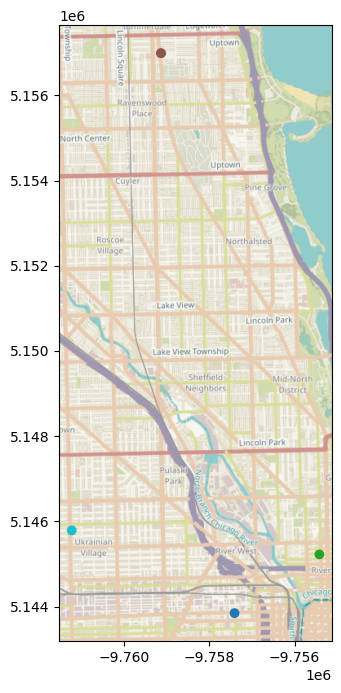

In [17]:
import contextily as cx
from data.constants import WEB_CRS
# Spot check id clusters.
plot_cols = ['station_cluster_id','station_cluster_centroid','geometry']
plot_data = name_clusters[(~is_name_multi_cluster & is_id_multi_cluster)][plot_cols].drop_duplicates()
plot_station = plot_data['station_cluster_id'].sample(5)
plot_data = plot_data[plot_data.station_cluster_id.isin(plot_station)]
fig = plot_data.to_crs(WEB_CRS).plot("station_cluster_id", figsize=(8,8))
cx.add_basemap(ax=fig, attribution=False)
# Looks ok.

In [18]:
# Finally assign the labels.
bike_rides = bike_rides.assign(station_cluster_id = cluster_ids,
                               station_cluster_centroid = cluster_centroids)

# Pipeline Out

In [21]:
bike_rides = (bike_rides
                .assign(station_cluster_centroid = bike_rides.station_cluster_centroid.apply(to_wkb)))


In [22]:
bike_rides.to_parquet(bike_rides_out, index=False)